# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Каюмов Эмиль Марселевич

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [2]:
data_train = pd.read_csv('unimel_train.csv')
data_test  = pd.read_csv('unimel_test.csv')

y_train = data_train['Grant.Status']
y_test  = data_test['Grant.Status']

data_train.drop('Grant.Status', axis=1, inplace=True)
data_test.drop('Grant.Status',  axis=1, inplace=True)

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

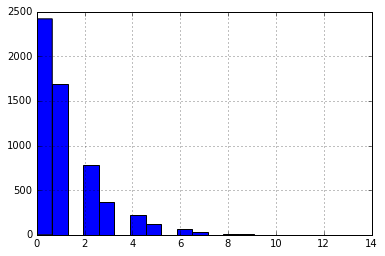

In [3]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

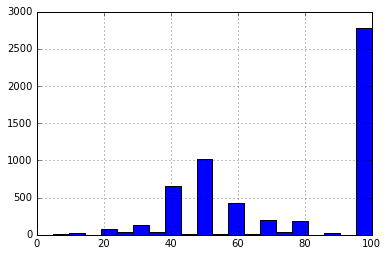

In [4]:
data_train['RFCD.Percentage.1'].hist(bins=20)

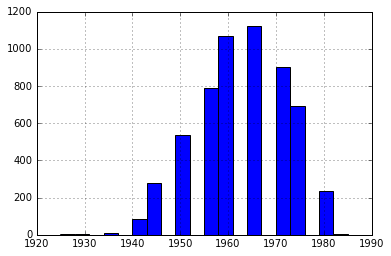

In [5]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

Признаки распределены неравномерно, что не очень хорошо для линейных методов (малоразделимы малые изменения признаков и большое влияние, если признак шумовое или просто принмиает большое значение). Масштабирование может привести распределение к равномерному. 

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

In [6]:
print '1.', data_train.isnull().sum().sum()
print '2.', (data_train.isnull().sum(axis=1) != 0).sum()
print '3.', (data_train.isnull().sum(axis=0) != 0).sum()

1. 26843
2. 5879
3. 38


Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [7]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [8]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print simple_data_dict

[{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}]


In [9]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
transformer.fit_transform(simple_data_dict)

array([[ 1.,  0.,  0.,  1.,  0.],
       [ 0.,  1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.]])

Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [10]:
def transform_data(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorical_cols = list(set(data.columns) - set(numeric_cols))
    
    # nan
    data[numeric_cols] = data[numeric_cols].fillna(0)
    data[categorical_cols] = data[categorical_cols].fillna('nan').astype(str)
    
    # scaling and one-hot encodeing
    if is_test:
        data[numeric_cols] = scaler.transform(data[numeric_cols])
        dummies = transformer.transform(data[categorical_cols].T.to_dict().values())
        data.drop(categorical_cols, axis=1, inplace=True)
        data = pd.concat((data, pd.DataFrame(dummies, columns=transformer.feature_names_)), axis=1)
    else:
        data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
        dummies = transformer.fit_transform(data[categorical_cols].T.to_dict().values())
        data.drop(categorical_cols, axis=1, inplace=True)
        data = pd.concat((data, pd.DataFrame(dummies, columns=transformer.feature_names_)), axis=1)
        
    return data, scaler, transformer

Применяем функцию к данным:

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [12]:
print X.shape[1]

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [13]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [14]:
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param = {'C' : C_grid}

gs = GridSearchCV(LogisticRegression(penalty='l2'), param, scoring='roc_auc', n_jobs=-1, cv=cv)
gs.fit(X, y_train)
print 'score:', gs.best_score_
print 'param:', gs.best_params_

score: 0.882387153883
param: {'C': 0.1}


In [15]:
lr = LogisticRegression(C=0.1, penalty='l2')
lr.fit(X, y_train)
predict = lr.predict_proba(X_test)[:, 1]
print 'auc:', roc_auc_score(y_test, predict)

auc: 0.880340804287


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [16]:
for C in C_grid:
    lr = LogisticRegression(C=C, penalty='l1')
    lr.fit(X, y_train)
    print 'C:', '%5.g' % C, '| non zero:', np.sum(lr.coef_.reshape(-1) != 0)

C: 0.001 | non zero: 0
C:  0.01 | non zero: 9
C:   0.1 | non zero: 58
C:     1 | non zero: 668
C: 1e+01 | non zero: 2427
C: 1e+02 | non zero: 2859


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [17]:
lr = LogisticRegression(C=0.01, penalty='l1')
lr.fit(X, y_train)
predict = lr.predict_proba(X_test)[:, 1]
print 'auc:', roc_auc_score(y_test, predict)
print 'features:', np.sum(lr.coef_.reshape(-1) != 0)

auc: 0.852547334256
features: 9


#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [18]:
lr = LogisticRegression(C=0.1, penalty='l2')
lr.fit(X, y_train)
predict = lr.predict_proba(X_test)[:, 1]

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [19]:
from sklearn.metrics import log_loss, average_precision_score

print 'auc:', roc_auc_score(y_test, predict)
print 'auc-pr:', average_precision_score(y_test, predict)
print 'logloss:', log_loss(y_test, predict)

auc: 0.880340804287
auc-pr: 0.838749398732
logloss: 0.442742039295


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

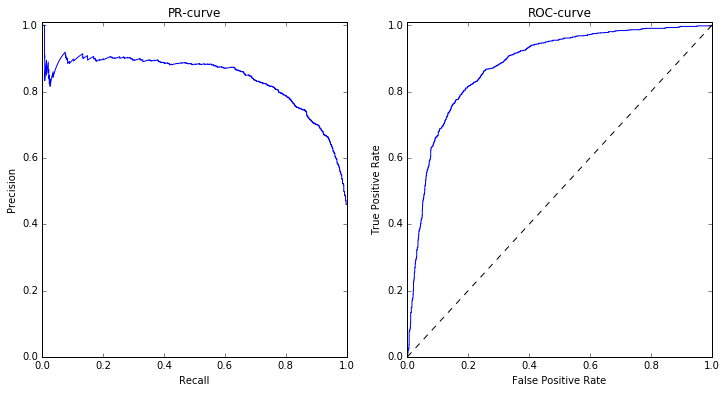

In [20]:
from sklearn.metrics import precision_recall_curve, roc_curve

precision, recall, threshold = precision_recall_curve(y_test, predict)
fpr, tpr, _ = roc_curve(y_test, predict)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(recall, precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('PR-curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('ROC-curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [21]:
arg = np.argmax(precision[recall >= 0.9])
threshold_fix = threshold[(recall >= 0.9)[:-1]][arg]
precision_fix = precision[recall >= 0.9][arg]
recall_fix    = recall[recall >= 0.9][arg]
print 'precision with 0.9 recall: %2.5f' % precision_fix
print 'threshold with 0.9 recall: %2.5f' % threshold_fix

precision with 0.9 recall: 0.70195
threshold with 0.9 recall: 0.31491


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [22]:
print 'f1score: %2.4f' % (2 * precision_fix * recall_fix / (precision_fix + recall_fix)) 

f1score: 0.7888


Низкое значение F1 получилось таким по причине того, что Precision принимает не слишком высокое значение при заданном Recall.

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [23]:
arg = np.argmax(recall[precision >= 0.8])
threshold_fix = threshold[(precision >= 0.8)[:-1]][arg]
precision_fix = precision[precision >= 0.8][arg]
recall_fix    = recall[precision >= 0.8][arg]
print 'recall    with 0.8 precision: %2.5f' % recall_fix
print 'threshold with 0.8 precision: %2.5f' % threshold_fix

recall    with 0.8 precision: 0.77602
threshold with 0.8 precision: 0.52899


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [24]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    
    plt.figure(figsize=(5, 5))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

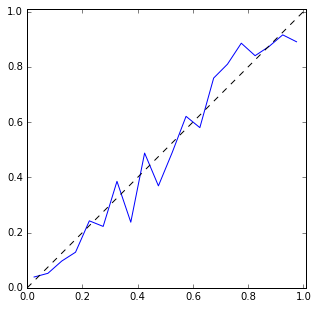

In [25]:
clf = LogisticRegression(C=0.1)
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

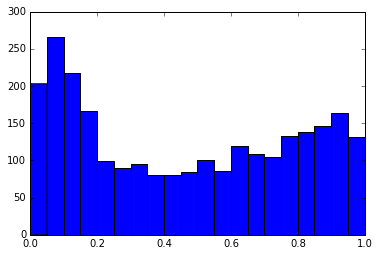

In [26]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [27]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

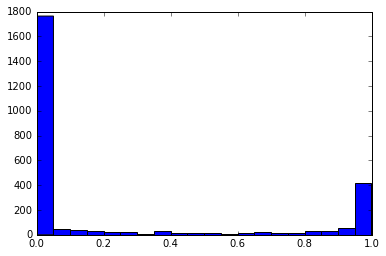

In [28]:
plt.hist(preds, bins=20)
plt.show()

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

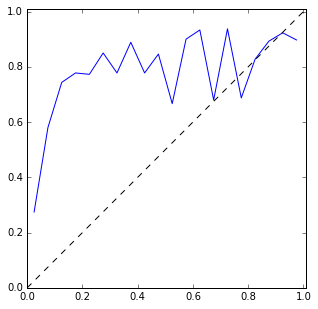

In [29]:
plot_calibration_curve(y_test, preds)

Видим, что вероятности распределены неравномерно (по распределению видно, что всё либо близко к нулю, либо к единице).

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

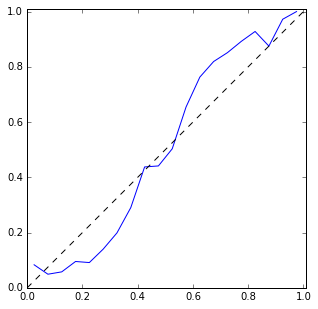

In [30]:
from sklearn.calibration import CalibratedClassifierCV
cal_clf = CalibratedClassifierCV(SGDClassifier(), cv=5)
cal_clf.fit(X, y_train)
preds = cal_clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Стало ровнее, спорить не будем.

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

Слишком сложное задание.

                /\ /l
               ((.Y(!
                \ |/
                /  6~6,
                \ _    +-.
                 \`-=--^-'
                  \ \
                 _/  \
                (  .  Y
               /"\ `--^--v--.
              / _ `--"T~\/~\/
             / " ~\.  !
       _    Y      Y./'
      Y^|   |      |~~7
      | l   |     / ./'
      | `L  | Y .^/~T
      |  l  ! | |/| |
      | .`\/' | Y | !
      l  "~   j l j_L______
       \,____{ __"~ __ ,\_,\_
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [31]:
X      = pd.concat((pd.DataFrame(np.ones(X.shape[0]), columns=['one']), X), axis=1)
X_test = pd.concat((pd.DataFrame(np.ones(X_test.shape[0]), columns=['one']), X_test), axis=1)

y_train = y_train * 2 - 1
y_test  = y_test  * 2 - 1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [32]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    return 1.0 / (1.0 + np.exp(-X.dot(w)))

In [33]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
     return np.sum(np.log(1 + np.exp(- X.dot(w) * y))) / X.shape[0]

In [34]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    return np.sum((1.0 / (1.0 + np.exp(X.dot(w) * y))).reshape((-1, 1)) * X * y.reshape((-1, 1)), axis=0) / X.shape[0] 

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [35]:
def grad_descent(X, y, step_size, max_iter):
    
    w = np.random.uniform(-0.01, 0.01, size=X.shape[1])
    X = np.array(X)
    y = np.array(y)
    
    iterations = []
   
    for i in range(max_iter):
        w += step_size * get_grad(w, X, y)
        iterations.append(get_func(w, X, y))
        
    return w, iterations

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

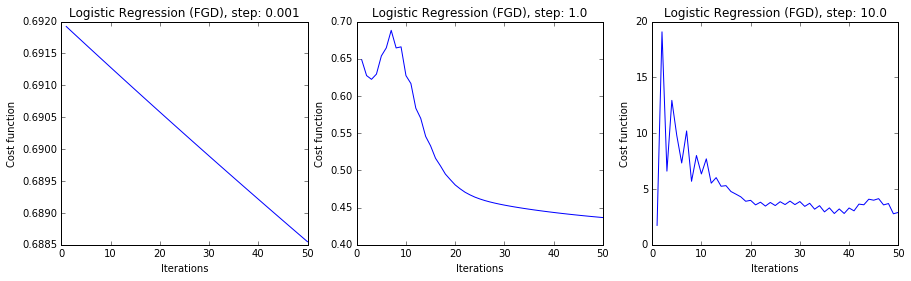

In [36]:
w1, iterations1 = grad_descent(X, y_train, 0.001, 50)
w2, iterations2 = grad_descent(X, y_train, 1.0,   50)
w3, iterations3 = grad_descent(X, y_train, 10.0,  50)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(iterations1) + 1), iterations1)
plt.title('Logistic Regression (FGD), step: 0.001')
plt.xlabel('Iterations')
plt.ylabel('Cost function')

plt.subplot(1, 3, 2)
plt.plot(range(1, len(iterations2) + 1), iterations2)
plt.title('Logistic Regression (FGD), step: 1.0')
plt.xlabel('Iterations')
plt.ylabel('Cost function')

plt.subplot(1, 3, 3)
plt.plot(range(1, len(iterations3) + 1), iterations3)
plt.title('Logistic Regression (FGD), step: 10.0')
plt.xlabel('Iterations')
plt.ylabel('Cost function')

plt.show()

Видим, что для шага 0.001 сходимость похожа на линейную, при этом за 50 итераций метод не сходится к конкретному значению. В третьем случае для шага 10 после резких колебаний появляется стабильность, однако метод не сходится к тому же значению, что в метод с шагом 1.0, из-за большого шага. Лучше всего подходит шаг 1.0.

In [37]:
w, _ = grad_descent(X, y_train, 1.0, 50)
predict = make_pred(X_test, w)
print 'auc:', roc_auc_score(y_test, predict)

auc: 0.866724908186


Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [38]:
def sgd(X, y, step_size, max_iter):
    
    w = np.random.uniform(-0.1, 0.1, size=X.shape[1])
    X = np.array(X)
    y = np.array(y)
    
    iterations = []
   
    for i in range(max_iter):
        index = np.random.randint(0, X.shape[0])
        w += step_size * get_grad(w, X[index], y[index])
        iterations.append(get_func(w, X, y))
    
    return w, iterations 

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

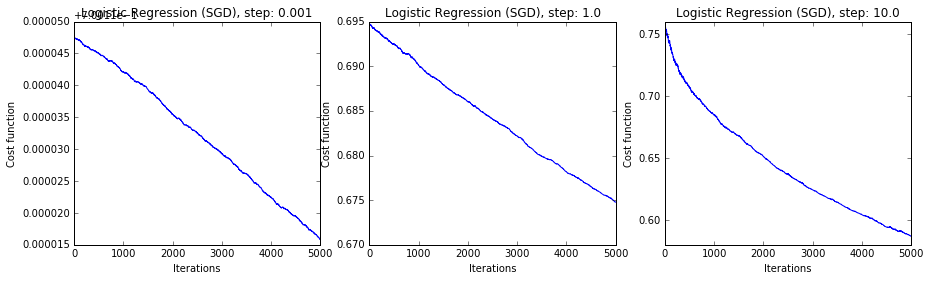

In [39]:
w1, iterations1 = sgd(X, y_train, 0.001, 5000)
w2, iterations2 = sgd(X, y_train, 1.0,   5000)
w3, iterations3 = sgd(X, y_train, 10.0,  5000)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(iterations1) + 1), iterations1)
plt.title('Logistic Regression (SGD), step: 0.001')
plt.xlabel('Iterations')
plt.ylabel('Cost function')

plt.subplot(1, 3, 2)
plt.plot(range(1, len(iterations2) + 1), iterations2)
plt.title('Logistic Regression (SGD), step: 1.0')
plt.xlabel('Iterations')
plt.ylabel('Cost function')

plt.subplot(1, 3, 3)
plt.plot(range(1, len(iterations3) + 1), iterations3)
plt.title('Logistic Regression (SGD), step: 10.0')
plt.xlabel('Iterations')
plt.ylabel('Cost function')

plt.show()

In [40]:
w, _ = sgd(X, y_train, 10.0, 5000)
predict = make_pred(X_test, w)
print 'auc:', roc_auc_score(y_test, predict)

auc: 0.793956818327


Заметим, что прототипы функций не включали в себя параметр регуляризации и параметр для оценки сходимости метода, поэтому был реализован самый просто вариант логистической регрессии. Однако несложно добавить это: плюс слагаемое в градиенте и функции потерь, одно условие на проверку сходимости в цикле по итерациям

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [41]:
data_train = pd.read_csv('unimel_train.csv')
data_test  = pd.read_csv('unimel_test.csv')

y_train = data_train['Grant.Status']
y_test  = data_test['Grant.Status']

data_train.drop('Grant.Status', axis=1, inplace=True)
data_test.drop('Grant.Status',  axis=1, inplace=True)

In [42]:
def transform_data_2(data, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorical_cols = list(set(data.columns) - set(numeric_cols))
    
    # nan
    data[numeric_cols] = data[numeric_cols].fillna(0)
    data[categorical_cols] = data[categorical_cols].fillna('nan').astype(str)
    
    # scaling and one-hot encodeing
    if is_test:
        dummies = transformer.transform(data[categorical_cols].T.to_dict().values())
        data.drop(categorical_cols, axis=1, inplace=True)
        data = pd.concat((data, pd.DataFrame(dummies, columns=transformer.feature_names_)), axis=1)
    else:
        dummies = transformer.fit_transform(data[categorical_cols].T.to_dict().values())
        data.drop(categorical_cols, axis=1, inplace=True)
        data = pd.concat((data, pd.DataFrame(dummies, columns=transformer.feature_names_)), axis=1)
        
    return data, transformer

In [43]:
transformer = DictVectorizer(sparse=False)
X, transformer = transform_data_2(data_train, transformer, False)
X_test, _ = transform_data_2(data_test, transformer, True)

In [44]:
w, iterations = grad_descent(X, y_train, 1.0, 50)
predict = make_pred(X_test, w)
print 'auc:', roc_auc_score(y_test, predict)

auc: 0.501413776999


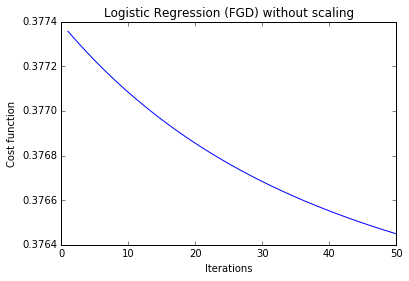

In [45]:
plt.plot(range(1, len(iterations) + 1), iterations)
plt.title('Logistic Regression (FGD) without scaling')
plt.xlabel('Iterations')
plt.ylabel('Cost function')

Здесь вы можете поделиться своими мыслями по поводу этой части.

Видим, что нормализацию проводить необходимо. Метод сходится, но результат плохой (сходимость медленная).

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [46]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве тестовой выборки. При каком значении этого параметра достигается наилучшее качество?

In [47]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
min_mse = np.inf
min_alpha = 0

for alpha in alpha_grid:
    ridge = Ridge(alpha)
    ridge.fit(X, y)
    predict = ridge.predict(X_test)
    mse = mean_squared_error(y_test, predict)
    if mse < min_mse:
        min_mse = mse
        min_alpha = alpha
        
print 'alpha:', min_alpha
print 'mse:', min_mse

alpha: 0.1
mse: 3096.03015101


Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [48]:
from sklearn.metrics import r2_score

ridge = Ridge(0.1)
ridge.fit(X, y)
predict = ridge.predict(X_test)

print 'rmse:', mean_squared_error(y_test, predict) ** 0.5
print 'r2score:', r2_score(y_test, predict)

rmse: 55.6419819113
r2score: 0.417024184822


Коэффициент детерминации принимает низкое значение. Модель не слишком хорошо описывает данные.